# **STUDENT AI** - MATH MODEL CREATION (CLASSIFICATION)

## Objectives

Output a usable model for predicting student performance for use in a streamlit dashboard.

## Inputs

Main Data set cleaned and engineered for model training.

## Outputs

Pipeline and .pkl file to use for predicting a students math score based on the derived calculated best feature variables.


---

# Import required libraries

In [2]:
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

### Pipeline
from sklearn.pipeline import Pipeline

### Feature Engineering
from feature_engine.encoding import OrdinalEncoder

### Feature Scaling
from sklearn.preprocessing import StandardScaler

### libraries for custom transformer
from sklearn.base import BaseEstimator, TransformerMixin

### Feature Balancing
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

### Feature  Selection
from sklearn.feature_selection import SelectFromModel

### ML algorithms 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier

### EqualFrequencyDiscretiser
from feature_engine.discretisation import EqualFrequencyDiscretiser

### packages for classification report and confusion matrix
from sklearn.metrics import make_scorer, recall_score

### Train test split
from sklearn.model_selection import train_test_split

### Packages for generating a classification report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix

### GridSearchCV
from sklearn.model_selection import GridSearchCV

print('All Libraries Loaded')

All Libraries Loaded


# Change working directory

### Set the working directory to notebook parent folder
If the output does not match, click **'clear all outputs'** and then **'restart'** the notebook. 
Then run cells from top to bottom.

In [3]:
current_dir = os.getcwd()
os.chdir(os.path.dirname(current_dir))
current_dir = os.getcwd()
print('If correct, Active Directory should read: /workspace/student-AI')
print(f"Active Directory: {current_dir}")

If correct, Active Directory should read: /workspace/student-AI
Active Directory: /workspace/student-AI


### Load cleaned dataset

In [4]:
df_maths = pd.read_csv('outputs/dataset/Expanded_data_with_more_features_clean.csv').filter(['Gender', 'EthnicGroup', 'ParentEduc', 'LunchType', 'TestPrep', 'MathScore'])
df_maths

,Gender,EthnicGroup,ParentEduc,LunchType,TestPrep,MathScore
0,female,group C,bachelor's degree,standard,none,71
1,female,group C,some college,standard,none,69
2,female,group B,master's degree,standard,none,87
3,male,group A,associate's degree,free/reduced,none,45
4,male,group C,some college,standard,none,76
...,...,...,...,...,...,...
30636,female,group D,high school,standard,none,59
30637,male,group E,high school,standard,none,58
30638,female,group C,high school,free/reduced,completed,61
30639,female,group D,associate's degree,standard,completed,82


* The classes represent the following ranges: 
{'MathScore': [-inf, 67.0, inf]} 



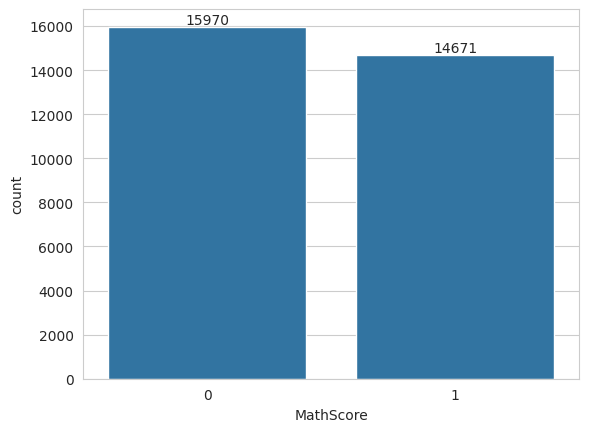

In [5]:
efd = EqualFrequencyDiscretiser(q=2, variables=['MathScore'])
df_maths_efd = efd.fit_transform(df_maths)

print(f"* The classes represent the following ranges: \n{efd.binner_dict_} \n")
fig_maths_efd = sns.countplot(data=df_maths_efd, x='MathScore')
plt.bar_label(fig_maths_efd.containers[0])
plt.show()

In [6]:
df_maths_efd

,Gender,EthnicGroup,ParentEduc,LunchType,TestPrep,MathScore
0,female,group C,bachelor's degree,standard,none,1
1,female,group C,some college,standard,none,1
2,female,group B,master's degree,standard,none,1
3,male,group A,associate's degree,free/reduced,none,0
4,male,group C,some college,standard,none,1
...,...,...,...,...,...,...
30636,female,group D,high school,standard,none,0
30637,male,group E,high school,standard,none,0
30638,female,group C,high school,free/reduced,completed,0
30639,female,group D,associate's degree,standard,completed,1


### Split Data Set into Train and Test sets

In [16]:
 math_train_features, math_test_features, math_train_scores, math_test_scores = train_test_split(
    df_maths_efd.drop(['MathScore'], axis=1),
    df_maths_efd['MathScore'],
    test_size = 0.2,
    random_state = 7
)

print("* Train set:", math_train_features.shape, math_train_scores.shape, "\n* Test set:",  math_test_features.shape, math_test_scores.shape)

* Train set: (24512, 5) (24512,) 
* Test set: (6129, 5) (6129,)


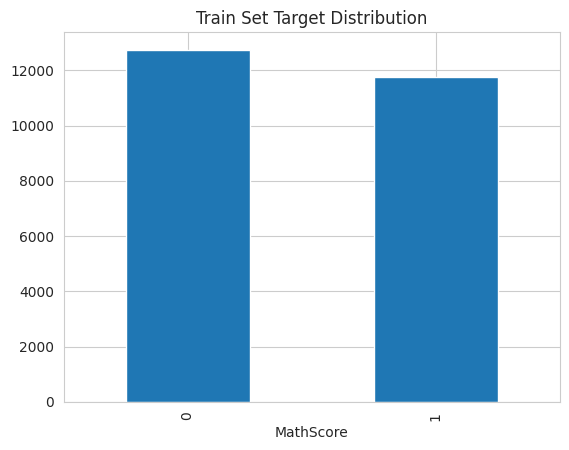

In [17]:
sns.set_style("whitegrid")
math_train_scores.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

In [18]:
feature_set = ['ParentEduc','EthnicGroup']

### Remove all other features...

In [20]:
math_train_features = math_train_features.filter(feature_set)
math_test_features = math_test_features.filter(feature_set)
math_test_features

,ParentEduc,EthnicGroup
28031,master's degree,group C
14300,bachelor's degree,group B
21304,some college,group D
19953,associate's degree,group E
28702,high school,group C
...,...,...
10709,associate's degree,group C
29370,some high school,group C
6591,some high school,group B
18170,associate's degree,group D


In [21]:
def PipelineOptimization(model):
    pipeline_base = Pipeline([

        ("OrdinalCategoricalEncoder", OrdinalEncoder(
            encoding_method='arbitrary', 
            variables=feature_set)),

        ("model", model),

    ])

    return pipeline_base

### Define best algorithm and hyperparameters

In [22]:
selected_model = {"AdaBoostClassifier": AdaBoostClassifier(random_state=0),}
selected_model_parameters = {"AdaBoostClassifier": {
    'model__n_estimators': [80],
    'model__learning_rate':[0.1],
    }
  }

selected_model_parameters

{'AdaBoostClassifier': {'model__n_estimators': [80],
  'model__learning_rate': [0.1]}}

### Final GridSearch CV

In [23]:
from sklearn.model_selection import GridSearchCV
class HyperparameterOptimizationSearch:

    def __init__(self, models, parameters):
        self.models = models
        self.parameters = parameters
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, x, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model =  PipelineOptimization(self.models[key])

            parameters = self.parameters[key]
            grid_search = GridSearchCV(model, parameters, cv=cv, n_jobs=n_jobs, verbose=verbose, scoring=scoring)
            grid_search.fit(x, y)
            self.grid_searches[key] = grid_search

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, parameters):
            summary = {
                 'estimator': key,
                 'minimum_score': min(scores),
                 'maximum_score': max(scores),
                 'mean_score': np.mean(scores),
                 'standard_deviation_score': np.std(scores),
            }
            return pd.Series({**parameters,**summary})

        rows = []
        for k in self.grid_searches:
            parameters = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                result = self.grid_searches[k].cv_results_[key]        
                scores.append(result.reshape(len(parameters), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(parameters, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'minimum_score', 'mean_score', 'maximum_score', 'standard_deviation_score']
        columns = columns + [column for column in df.columns if column not in columns]

        return df[columns], self.grid_searches

In [24]:
math_model = HyperparameterOptimizationSearch(models=selected_model, parameters=selected_model_parameters)
math_model.fit(math_train_features, math_train_scores,
           scoring = make_scorer(recall_score, labels=[0], average=None),
           n_jobs=-1,cv=5)



Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


### Custom Confusion Matrix Function from CI Customer Churn Course

In [25]:
def confusion_matrix_and_report(x, y, pipeline, label_map):

  prediction = pipeline.predict(x)

  print('---  Confusion Matrix  ---')
  print(pd.DataFrame(confusion_matrix(y_true=prediction, y_pred=y),
        columns=[ ["Actual " + sub for sub in label_map] ], 
        index= [ ["Prediction " + sub for sub in label_map ]]
        ))
  print("\n")

  print('---  Classification Report  ---')
  print(classification_report(y, prediction, target_names=label_map),"\n")

def clf_performance(math_train_features, math_train_scores, math_test_features, math_test_scores, pipeline, label_map):
  print("#### Train Set #### \n")
  confusion_matrix_and_report(math_train_features, math_train_scores, pipeline, label_map)

  print("#### Test Set ####\n")
  confusion_matrix_and_report(math_test_features, math_test_scores, pipeline, label_map)

In [26]:
grid_search_summary_final, grid_search_pipelines_final = math_model.score_summary()
grid_search_summary_final

,estimator,minimum_score,mean_score,maximum_score,standard_deviation_score,model__learning_rate,model__n_estimators
0,AdaBoostClassifier,0.74186,0.753393,0.770498,0.010558,0.1,80


In [27]:
final_model = grid_search_summary_final.iloc[0,0]
final_model

'AdaBoostClassifier'

In [28]:
pipeline_clf_final = grid_search_pipelines_final[final_model].best_estimator_
pipeline_clf_final

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['ParentEduc', 'EthnicGroup'])),
                ('model',
                 AdaBoostClassifier(learning_rate=0.1, n_estimators=80,
                                    random_state=0))])

* These are the 2 most important features in descending order. The model was trained on them: 
['EthnicGroup', 'ParentEduc']


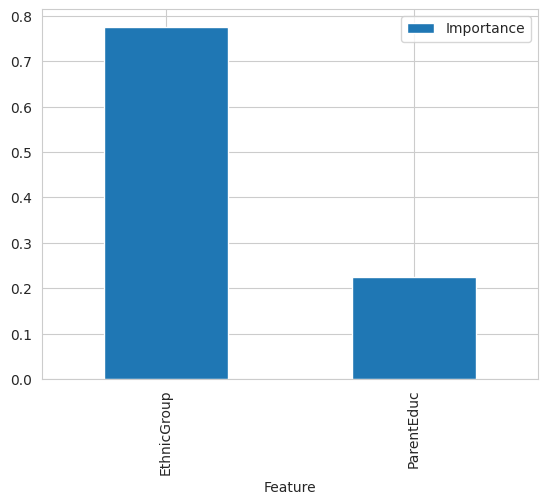

In [29]:
data_cleaning_feat_eng_steps = 1
columns_after_data_cleaning_feat_eng = (Pipeline(pipeline_clf_final.steps[:data_cleaning_feat_eng_steps])
                                        .transform(math_train_features)
                                        .columns)

# create DataFrame to display feature importance
df_feature_importance_final = (pd.DataFrame(data={
          'Feature': columns_after_data_cleaning_feat_eng,
          'Importance': pipeline_clf_final['model'].feature_importances_})
  .sort_values(by='Importance', ascending=False)
  )

best_features_final = df_feature_importance_final['Feature'].to_list() # reassign best features in order

# Most important features statement and plot
print(f"* These are the {len(best_features_final)} most important features in descending order. "
      f"The model was trained on them: \n{best_features_final}")

df_feature_importance_final.plot(kind='bar', x='Feature', y='Importance')
plt.show()

In [30]:
def confusion_matrix_and_report(x, y, pipeline, label_map):

  prediction = pipeline.predict(x)

  print('---  Confusion Matrix  ---')
  print(pd.DataFrame(confusion_matrix(y_true=prediction, y_pred=y),
        columns=[ ["Actual " + sub for sub in label_map] ], 
        index= [ ["Prediction " + sub for sub in label_map ]]
        ))
  print("\n")

  print('---  Classification Report  ---')
  print(classification_report(y, prediction, target_names=label_map),"\n")

def clf_performance(math_train_features, math_train_scores, math_test_features, math_test_scores, pipeline, label_map):
  print("#### Train Set #### \n")
  confusion_matrix_and_report(math_train_features, math_train_scores, pipeline, label_map)

  print("#### Test Set ####\n")
  confusion_matrix_and_report(math_test_features, math_test_scores, pipeline, label_map)

In [31]:
label_map = ['Might need assistance', 'No assistance needed']

In [32]:
clf_performance(math_train_features, math_train_scores, math_test_features, math_test_scores, pipeline_clf_final, label_map )


#### Train Set #### 

---  Confusion Matrix  ---
                                 Actual Might need assistance  \
Prediction Might need assistance                         9555   
Prediction No assistance needed                          3190   

                                 Actual No assistance needed  
Prediction Might need assistance                        6727  
Prediction No assistance needed                         5040  


---  Classification Report  ---
                       precision    recall  f1-score   support

Might need assistance       0.59      0.75      0.66     12745
 No assistance needed       0.61      0.43      0.50     11767

             accuracy                           0.60     24512
            macro avg       0.60      0.59      0.58     24512
         weighted avg       0.60      0.60      0.58     24512
 

#### Test Set ####

---  Confusion Matrix  ---
                                 Actual Might need assistance  \
Prediction Might need assistance     

## Create Final Model Files

#### Check variable content before saving

In [34]:
# math_train_features.head()
# math_train_scores.head()
# math_test_features.head()
# math_test_scores.head()

### Set Model Type / Version and destination

In [35]:
version = "v1"
target = "math"

file_path = f"outputs/models/{target}/{version}"
file_path

'outputs/models/math/v1'

### Output files

*** Removing previous files  ***
outputs/models/math/v1/math-train-features.csv removed
outputs/models/math/v1/math-train-scores.csv removed
outputs/models/math/v1/math-test-features.csv removed
outputs/models/math/v1/math-test-scores.csv removed
outputs/models/math/v1/math-model.pkl removed
outputs/models/math/v1/math-labels.pkl removed
outputs/models/math/v1/math-feature-importance.png removed

*** Creating files in: outputs/models/math/v1 ***
math-train-features.csv created
math-train-scores.csv created
math-test-features.csv created
math-test-scores.csv created
math_model.pkl created
math_labels created


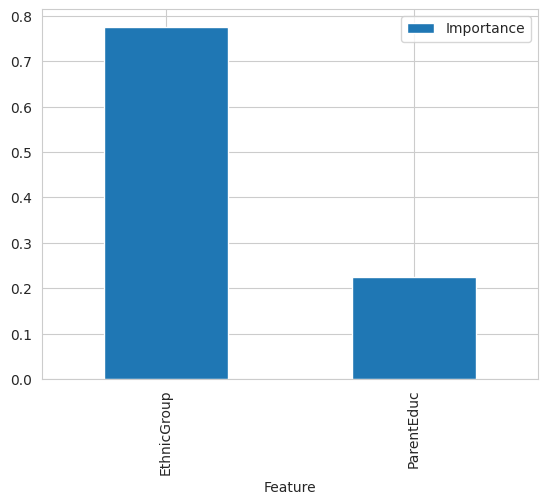

In [36]:
# Define which files to save/update
file_names = [
    f"{target}-train-features.csv",
    f"{target}-train-scores.csv",
    f"{target}-test-features.csv",
    f"{target}-test-scores.csv",
    f"{target}-model.pkl",
    f"{target}-labels.pkl",
    f"{target}-feature-importance.png",
]

# Ensure the directory exists
os.makedirs(file_path, exist_ok=True)

# Remove files if they exist
print(f'*** Removing previous files  ***')
for name in file_names:
    file = os.path.join(file_path, name)
    if os.path.exists(file):
        os.remove(file)
        print(f"{file} removed")
    else:
        print(f"{file} does not exist")

print('')

# Save .csv files
print(f'*** Creating files in: {file_path} ***')

math_train_features.to_csv(f"{file_path}/{target}-train-features.csv", index=False)
print(f'math-train-features.csv created')

math_train_scores.to_csv(f"{file_path}/{target}-train-scores.csv", index=False)
print(f'math-train-scores.csv created')

math_test_features.to_csv(f"{file_path}/{target}-test-features.csv", index=False)
print(f'math-test-features.csv created')

math_test_scores.to_csv(f"{file_path}/{target}-test-scores.csv", index=False)
print(f'math-test-scores.csv created')

# Save .pkl model files
joblib.dump(value=pipeline_clf_final, filename=f"{file_path}/{target}-model.pkl")
print(f'math_model.pkl created')

joblib.dump(value=label_map, filename=f"{file_path}/{target}-labels.pkl")
print(f'math_labels created')

# Save features plot image
df_feature_importance_final.plot(kind='bar',x='Feature',y='Importance')
plt.savefig(f'{file_path}/{target}-feature-importance.png', bbox_inches='tight')

